# Fellowship.ai Challenge

The purpose of this notebook is to create a deep learning model to classify images using the Fast AI library and the Food-101 dataset. The target is a  >85% accuracy for top-1 for the test set, using a ResNet50 or smaller network with a reasonable set of augmentations.

Dataset:
https://course.fast.ai/datasets

Libraries:
We are going to work with the fastai V1 library which is based on Pytorch 1.0
https://docs.fast.ai/
https://pytorch.org/


### Set up & Libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline 


In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

Setting the path to access and process the data

In [3]:
path=Path('/home/jupyter/Alex/Food101')
path_photos = path/'Images_data/food-101/images'


Downloading the data and extract it

In [4]:
from pathlib import Path
import urllib.request
import tarfile

In [19]:
# These 4 lines of code download the data set

#url = 'https://s3.amazonaws.com/fast-ai-imageclas/food-101.tgz'
#file = path/'proj1_training_data.tar.gz'
#print("Downloading the data set from %s..." % (url,))
#urllib.request.urlretrieve(url,file)

# These for lines extract the data 

print("Extracting data from %s..." % (path,))
tarred_file = tarfile.open(path/'proj1_training_data.tar.gz')
tarred_file.extractall('Images_data')
tarred_file.close()


Opening using tarfile from /home/jupyter/Alex/Food101...


## Food 101 - dataset

Food-101 is a dataset consisting of 101,000 images of 101 different food classes. 

I will use 75% of these images to train my model and 25% to validate the model.
Training set: 75750 images
Validation set: 25250 images

The dataset provides a list of images for training as well as another list for testing but I will create my own list as some images on this list are missing from the dataset.

The structure of the dataset is the following: There are 101 folders corresponding to each of the 101 classes. Each of these 101 folders contain 1000 images

### Create train a validation images list.

This code gets the filename of each images and its category.

In [67]:
data__=[]
for root, dirs, files in os.walk(path_photos):
    for file in files:
        if file.endswith(".jpg"):
            parts=(root.split('/'))
            parts=parts[-2:]
            char=parts[1]
            path_=(os.path.join(char, file))
            data__.append([char,path_])


In [37]:
len(data__) # I check that the length equals the number of images. Number of images = 101.000

101000

In [38]:
data__[0:2] # example of the 2 first items of the list.

[['chocolate_cake', 'chocolate_cake/181339.jpg'],
 ['chocolate_cake', 'chocolate_cake/3163827.jpg']]

In [39]:
# I randomly select the indexes that will form the test set.
import random
idx=random.sample(range(1, len(data__)), int(len(data__)*0.25))
idx.sort()
len(idx) # This is the number of items in the test set.

25250

In [40]:
# I split the data set between train and test data set using the indexes previously calculated.
train_image_list=[]
test_image_list=[]
for i in range(len(data__)):
    if i in idx:
        test_image_list.append(data__[i])
    else:
        train_image_list.append(data__[i])

In [41]:
# I convert both lists as panda. I will use these 2 files to create the DataBunch object
train_image_list_pd= pd.DataFrame(train_image_list)
test_image_list_pd= pd.DataFrame(test_image_list)
train_image_list_pd.head()

,0,1
0,chocolate_cake,chocolate_cake/181339.jpg
1,chocolate_cake,chocolate_cake/3163827.jpg
2,chocolate_cake,chocolate_cake/1295271.jpg
3,chocolate_cake,chocolate_cake/3688150.jpg
4,chocolate_cake,chocolate_cake/3603070.jpg


In [42]:
# I save the panda in the local drive as a as a csv 
train_image_list_pd.to_csv(path/"data/train_image_list.csv", index=False)

In [43]:
test_image_list_pd.to_csv(path/"data/test_image_list.csv", index=False)

Now I need to make sure that the datasets are more os less balanced.

In [4]:
train_image_list_pd = pd.read_csv(path/"data/train_image_list.csv")
test_image_list_pd=pd.read_csv(path/"data/test_image_list.csv")

In [7]:
def CountFrequency(train_list,test_list): 
  
    # Creating an empty dictionary  
    freq_train = {} 
    freq_test={}
    for item in train_list: 
        if (item in freq_train): 
            freq_train[item] += 1
        else: 
            freq_train[item] = 1
  
    for item in test_list: 
      if (item in freq_test): 
          freq_test[item] += 1
      else: 
          freq_test[item] = 1

    f = plt.figure(figsize=(12,3))
    plt.subplot(1, 2, 1)
    plt.title('Freq analysis train data set')
    plt.ylabel('Frequency')
    plt.xlabel('Number of photos per category')
    plt.bar(freq_train.keys(), freq_train.values(),color='g')
    
    plt.subplot(1, 2, 2)
    plt.title('Freq analysis validation data set')
    plt.ylabel('Frequency')
    plt.xlabel('Number of photos per category ')
    plt.bar(freq_test.keys(), freq_test.values(), color='r')

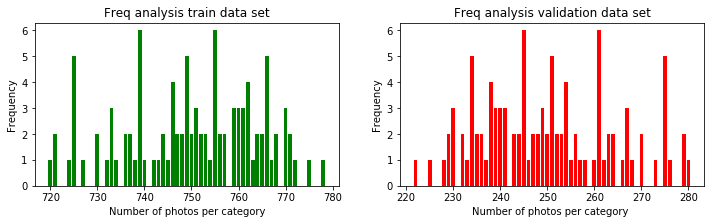

In [8]:
f_train=train_image_list_pd['0'].value_counts().tolist()
f_test=test_image_list_pd['0'].value_counts().tolist()
CountFrequency(f_train,f_test)

All the data sets are balanced ( between 720 - 780 photos )

### Create DataBunch

Now I create the DataBunch object which is used inside Learner to train a model.


    a) The batch size (bs) is 64 due to hardware contrains.
    b) I will perform some transformations ( aka data augmentation ) to the training set in order to increase the accuracy of the algorithm. This transformations are provided by the FastAI library
    c) I define the main_image_list ( which will act as the training set ) and the test_image_list which will act as the validation set. For that I am using the panda created previously
    d) I resize the set from 512x512 to 299x299 in order to accelerate the training. If I don't achive the goal ( 85% accuracy ) I will undo this.
    e) I normalize the databunch using Imagenet values which I think will be sufficient to achive the goal. If not, I will normalize the dataset using its own values ( mean / stdev )


In [52]:
bs=64

my_tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=45, max_zoom=1.15, max_lighting=0.2,
                     max_warp=None, p_affine=1, p_lighting=.45)

main_image_list=ImageList.from_df(df=train_image_list_pd,path=path_photos, cols=1)

test_image_list=ImageList.from_df(df=test_image_list_pd,path=path_photos, cols=1)


data=(main_image_list
      .split_by_list(main_image_list,test_image_list)
      .label_from_df(cols=0)         
      .transform(my_tfms, size=299)
      .databunch(bs=bs)).normalize(imagenet_stats)


This is an extract of the data

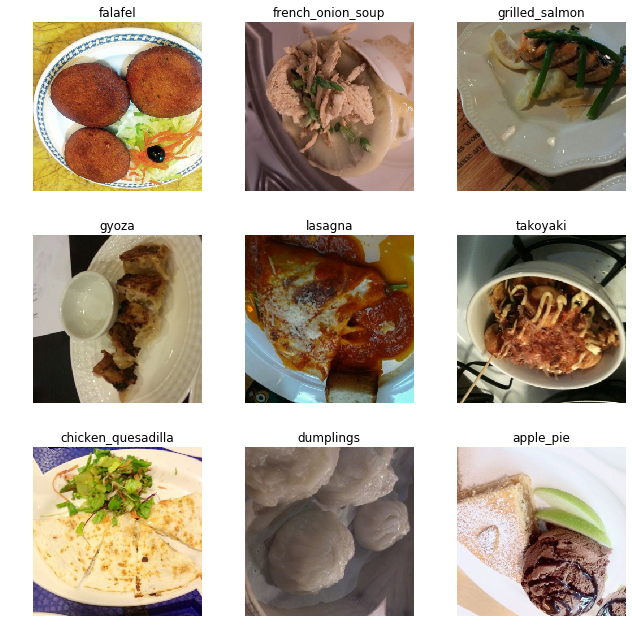

In [11]:
data.show_batch(rows=3, figsize=(9, 9))

I have a look at what the transforms actually do to the image:

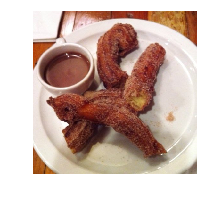

In [91]:
def get_ex(): return open_image(path_photos/'churros/1004234.jpg')
image=get_ex()
image.show()
# original Image

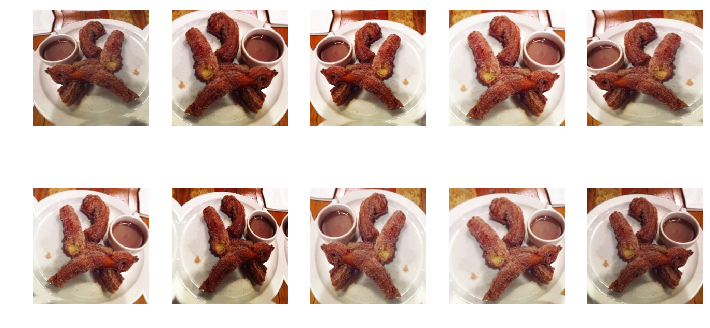

In [23]:
def show_transforms(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(get_transforms()[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

show_transforms(2, 5, 12, 6, size=224)



In [54]:
len(data.classes),data.c # i check that the databunch contains the 101 classes


(101, 101)

In [55]:
print(data) # Check that the train set / validation set look as expected.

ImageDataBunch;

Train: LabelList (75750 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
chocolate_cake,chocolate_cake,chocolate_cake,chocolate_cake,chocolate_cake
Path: /home/jupyter/Alex/Food101/Images_data/food-101/images;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
chocolate_cake,chocolate_cake,chocolate_cake,chocolate_cake,chocolate_cake
Path: /home/jupyter/Alex/Food101/Images_data/food-101/images;

Test: None


In [56]:
# I save the dataBunch 
with open(path/'data/food_images_bs64_s299.pkl', "wb") as f:
    pickle.dump(data, f)

In [9]:
with open(path/'data/food_images_bs64_s299.pkl', "rb") as f:
     data=pickle.load(f)

### Learner


Now I define the learner.


I will apply transfer learning using a pretrained model ( Resnet50). The learner - cnn_learner - will remove the last layer from the resnet50 ( classification layer ) and adapt the model to our data set, which contains 101 classes.

For the metrics, I will look at the accuracy. 
  

In [58]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

### round 1: Resnet 50 - Model frozen - data: bs 64 & size 299

Learning rate finder plots lr vs loss relationship for a Learner. It helps to pick a good starting learning rate.

Min numerical gradient: 2.75E-02
Min loss divided by 10: 8.32E-03


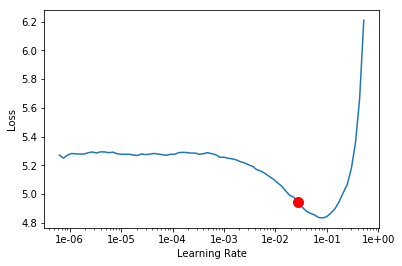

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)


I use the fit_one_cycle to train a network using Leslie Smith's 1cycle policy.
https://arxiv.org/pdf/1803.09820.pdf

In this first round, I am just training the latest layers added by the learner.

In [62]:
lr = 1e-2
learn.fit_one_cycle(2, lr)
learn.save(path/'models/food-101-test-1-cycle')


epoch,train_loss,valid_loss,accuracy,time
0,2.027254,1.864257,0.519525,10:14
1,1.355211,1.092148,0.712990,10:08


Max accuracy = 71.29%

Now, I unfreeze the whole model and apply the same process.

### round 2: Resnet 50 - Model unfrozen - data: bs 64 & size 299

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 3.98E-07


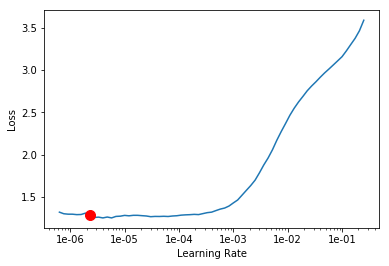

In [65]:
learn.load(path/'models/food-101-test-1-cycle'),
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)


For this second round, as the model is unfreeze, I will apply discriminative learning rates. It means that I different parts of the model will be trained with differnt learning rates.

This is done by passing lr=slice(start,end) which means that the first group's learning rate is start, the last is end, and the remaining are evenly spaced.

    1e-6 is the value suggested by the lr_finder
    1e-4 is the value before the slope goes upwards.


In [66]:
learn.fit_one_cycle(5, max_lr=slice(1e-6, 1e-4))
learn.save(path/'models/food-101-test-1-cycle-e5')


epoch,train_loss,valid_loss,accuracy,time
0,1.229419,1.060725,0.720000,13:01
1,1.159311,1.017879,0.735762,13:03
2,1.120240,0.956440,0.745941,13:02
3,1.029583,0.932633,0.752396,13:02
4,1.036157,0.926421,0.755089,13:03


Max accuracy = 75.5%

### round 3: Resnet 50 - Model unfrozen - data: bs 64 & size 299

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 5.25E-06


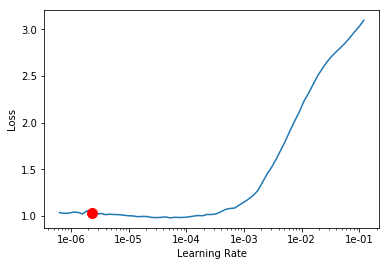

In [73]:
learn.load(path/'models/food-101-test-1-cycle-e5'),
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [69]:
learn.fit_one_cycle(5, max_lr=slice(1e-6, 2e-4))
learn.save(path/'models/food-101-test-1-cycle-e10')

epoch,train_loss,valid_loss,accuracy,time
0,1.021504,0.931988,0.753386,13:03
1,1.039830,0.899073,0.760238,13:02
2,0.938454,0.865797,0.770970,13:04
3,0.889410,0.840252,0.775327,13:03
4,0.845141,0.832915,0.776594,13:02


Max accuracy = 77.65%

### round 4: Resnet 50 - Model unfrozen - data: bs 64 & size 299

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.32E-07


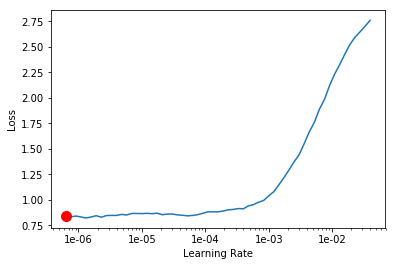

In [70]:
learn.load(path/'models/food-101-test-1-cycle-e10'),
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [71]:
learn.fit_one_cycle(5, max_lr=slice(1e-6, 2e-4))
learn.save(path/'models/food-101-test-1-cycle-e15')

epoch,train_loss,valid_loss,accuracy,time
0,0.914929,0.840568,0.774970,13:02
1,0.880315,0.826771,0.780515,13:02
2,0.874881,0.813245,0.784198,13:03
3,0.847316,0.786410,0.792515,13:03
4,0.759522,0.782545,0.793267,13:00


Max accuracy = 79.32%

### round 5: Resnet 50 - Model unfrozen - data: bs 32 & size 400

Nnow I will try to increase the accuracy by increasing the size of the images. 

Ideally I should train the model with 512x512 images and bs=32 but I can't fit all the data in the GPU. As I prefer to keep the bs as high as possible , I will try to achieve the goal ( 85% accuracy ) with 400x400 images. If it is not the case, I will reduce the batch size to 16 in order to be able to train the model using 512x512 images.



In [13]:

learn.destroy() # To release memory of the GPU

this Learner object self-destroyed - it still exists, but no longer usable


As I did previously...:

In [5]:
bs=32

my_tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=45, max_zoom=1.15, max_lighting=0.2,
                     max_warp=None, p_affine=1, p_lighting=.45)

main_image_list=ImageList.from_df(df=train_image_list_pd,path=path_photos, cols=1)

test_image_list=ImageList.from_df(df=test_image_list_pd,path=path_photos, cols=1)


data_400=(main_image_list
      .split_by_list(main_image_list,test_image_list)
      .label_from_df(cols=0)         
      .transform(my_tfms, size=400)
      .databunch(bs=bs)).normalize(imagenet_stats)

In [6]:
learn = cnn_learner(data_400, models.resnet50, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-06
Min loss divided by 10: 7.59E-04


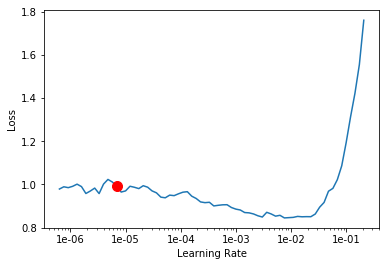

In [8]:
learn.load(path/'models/food-101-test-1-cycle-e15')

learn.lr_find()
learn.recorder.plot(suggestion=True)

In [9]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-5, 1e-3))
learn.save(path/'models/food-101-test-400-cycle-e5')

epoch,train_loss,valid_loss,accuracy,time
0,1.169975,1.034065,0.722535,22:24
1,1.142490,1.020403,0.726099,22:21
2,0.999865,0.850218,0.776079,22:21
3,0.796551,0.687722,0.814970,22:20
4,0.673821,0.655300,0.822535,22:21


Max accuracy = 82.25%

### round 6: Resnet 50 - Model unfrozen - data: bs 32 & size 400

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 9.12E-08


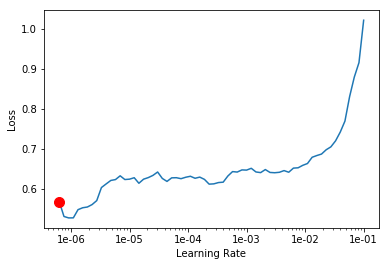

In [7]:
learn.load(path/'models/food-101-test-400-cycle-e5')
learn.lr_find()
learn.recorder.plot(suggestion=True)


In [8]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-7, 1e-3))
learn.save(path/'models/food-101-test-400-cycle-e10')

epoch,train_loss,valid_loss,accuracy,time
0,0.663752,0.655491,0.825584,22:23
1,0.671406,0.653654,0.825822,22:19
2,0.645811,0.646337,0.830257,22:19
3,0.603821,0.623318,0.835010,22:19
4,0.531492,0.622155,0.835802,22:19


Max accuracy = 83.58%

### round 7: Resnet 50 - Model unfrozen - data: bs 16 & size 512

Now, I increase the size of the images from 400x400 to 512x512. In order to allocate the bigger images, I have to reduce the bs from 32 to 16.

In [74]:
bs=16

my_tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=45, max_zoom=1.15, max_lighting=0.2,
                     max_warp=None, p_affine=1, p_lighting=.45)

main_image_list=ImageList.from_df(df=train_image_list_pd,path=path_photos, cols=1)

test_image_list=ImageList.from_df(df=test_image_list_pd,path=path_photos, cols=1)


data_512=(main_image_list
      .split_by_list(main_image_list,test_image_list)
      .label_from_df(cols=0)         
      .transform(my_tfms, size=512)
      .databunch(bs=bs)).normalize(imagenet_stats)

In [75]:
learn = cnn_learner(data_512, models.resnet50, metrics=accuracy)

In [12]:
learn.load(path/'models/food-101-test-400-cycle-e10');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 6.31E-08


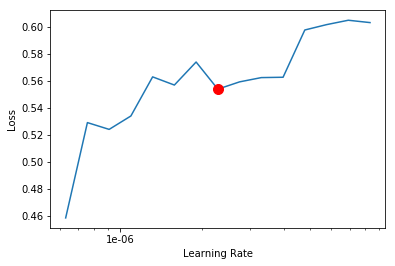

In [13]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [14]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-7, 1e-4))
learn.save(path/'models/food-101-test-512-cycle')

epoch,train_loss,valid_loss,accuracy,time
0,0.685310,0.639349,0.830574,34:53
1,0.681075,0.629992,0.833109,34:49
2,0.620488,0.626700,0.835644,34:49
3,0.611458,0.623232,0.835446,34:50
4,0.627826,0.630503,0.834891,34:50


Max accuracy = 83.48%

### Applying TTA to the round 7

TTA refers to 'Test Time Augmentation' and helps to improve the accuracy of the model.


In [77]:
# TTA
learn.load(path/'models/food-101-test-512-cycle');

In [78]:
log_preds_TTA,y_TTA = learn.TTA()


In [79]:
accuracy(log_preds_TTA,y_TTA)


tensor(0.8392)

Max accuracy = 83.92%

### Analysis of the results

Although I have not achieve the goal of >85%, I really think that my model performs quite well.


I will plot the images with higher top losses using the fastAI function interp.

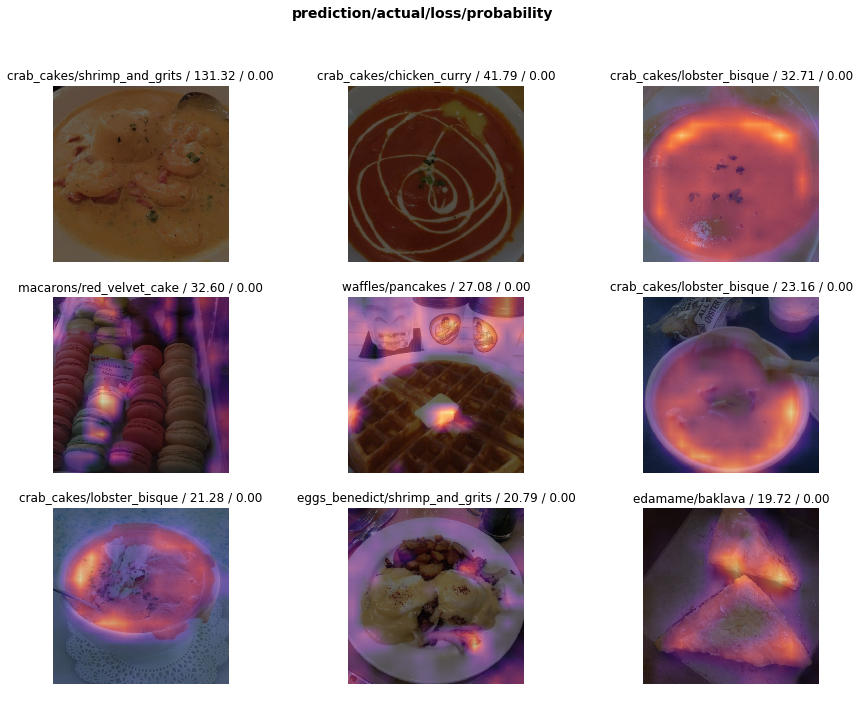

In [80]:
interp = ClassificationInterpretation.from_learner(learn)

interp.plot_top_losses(9, figsize=(15,11))


I can plot the confusion matrix but due the number of classes, it is not very usefull

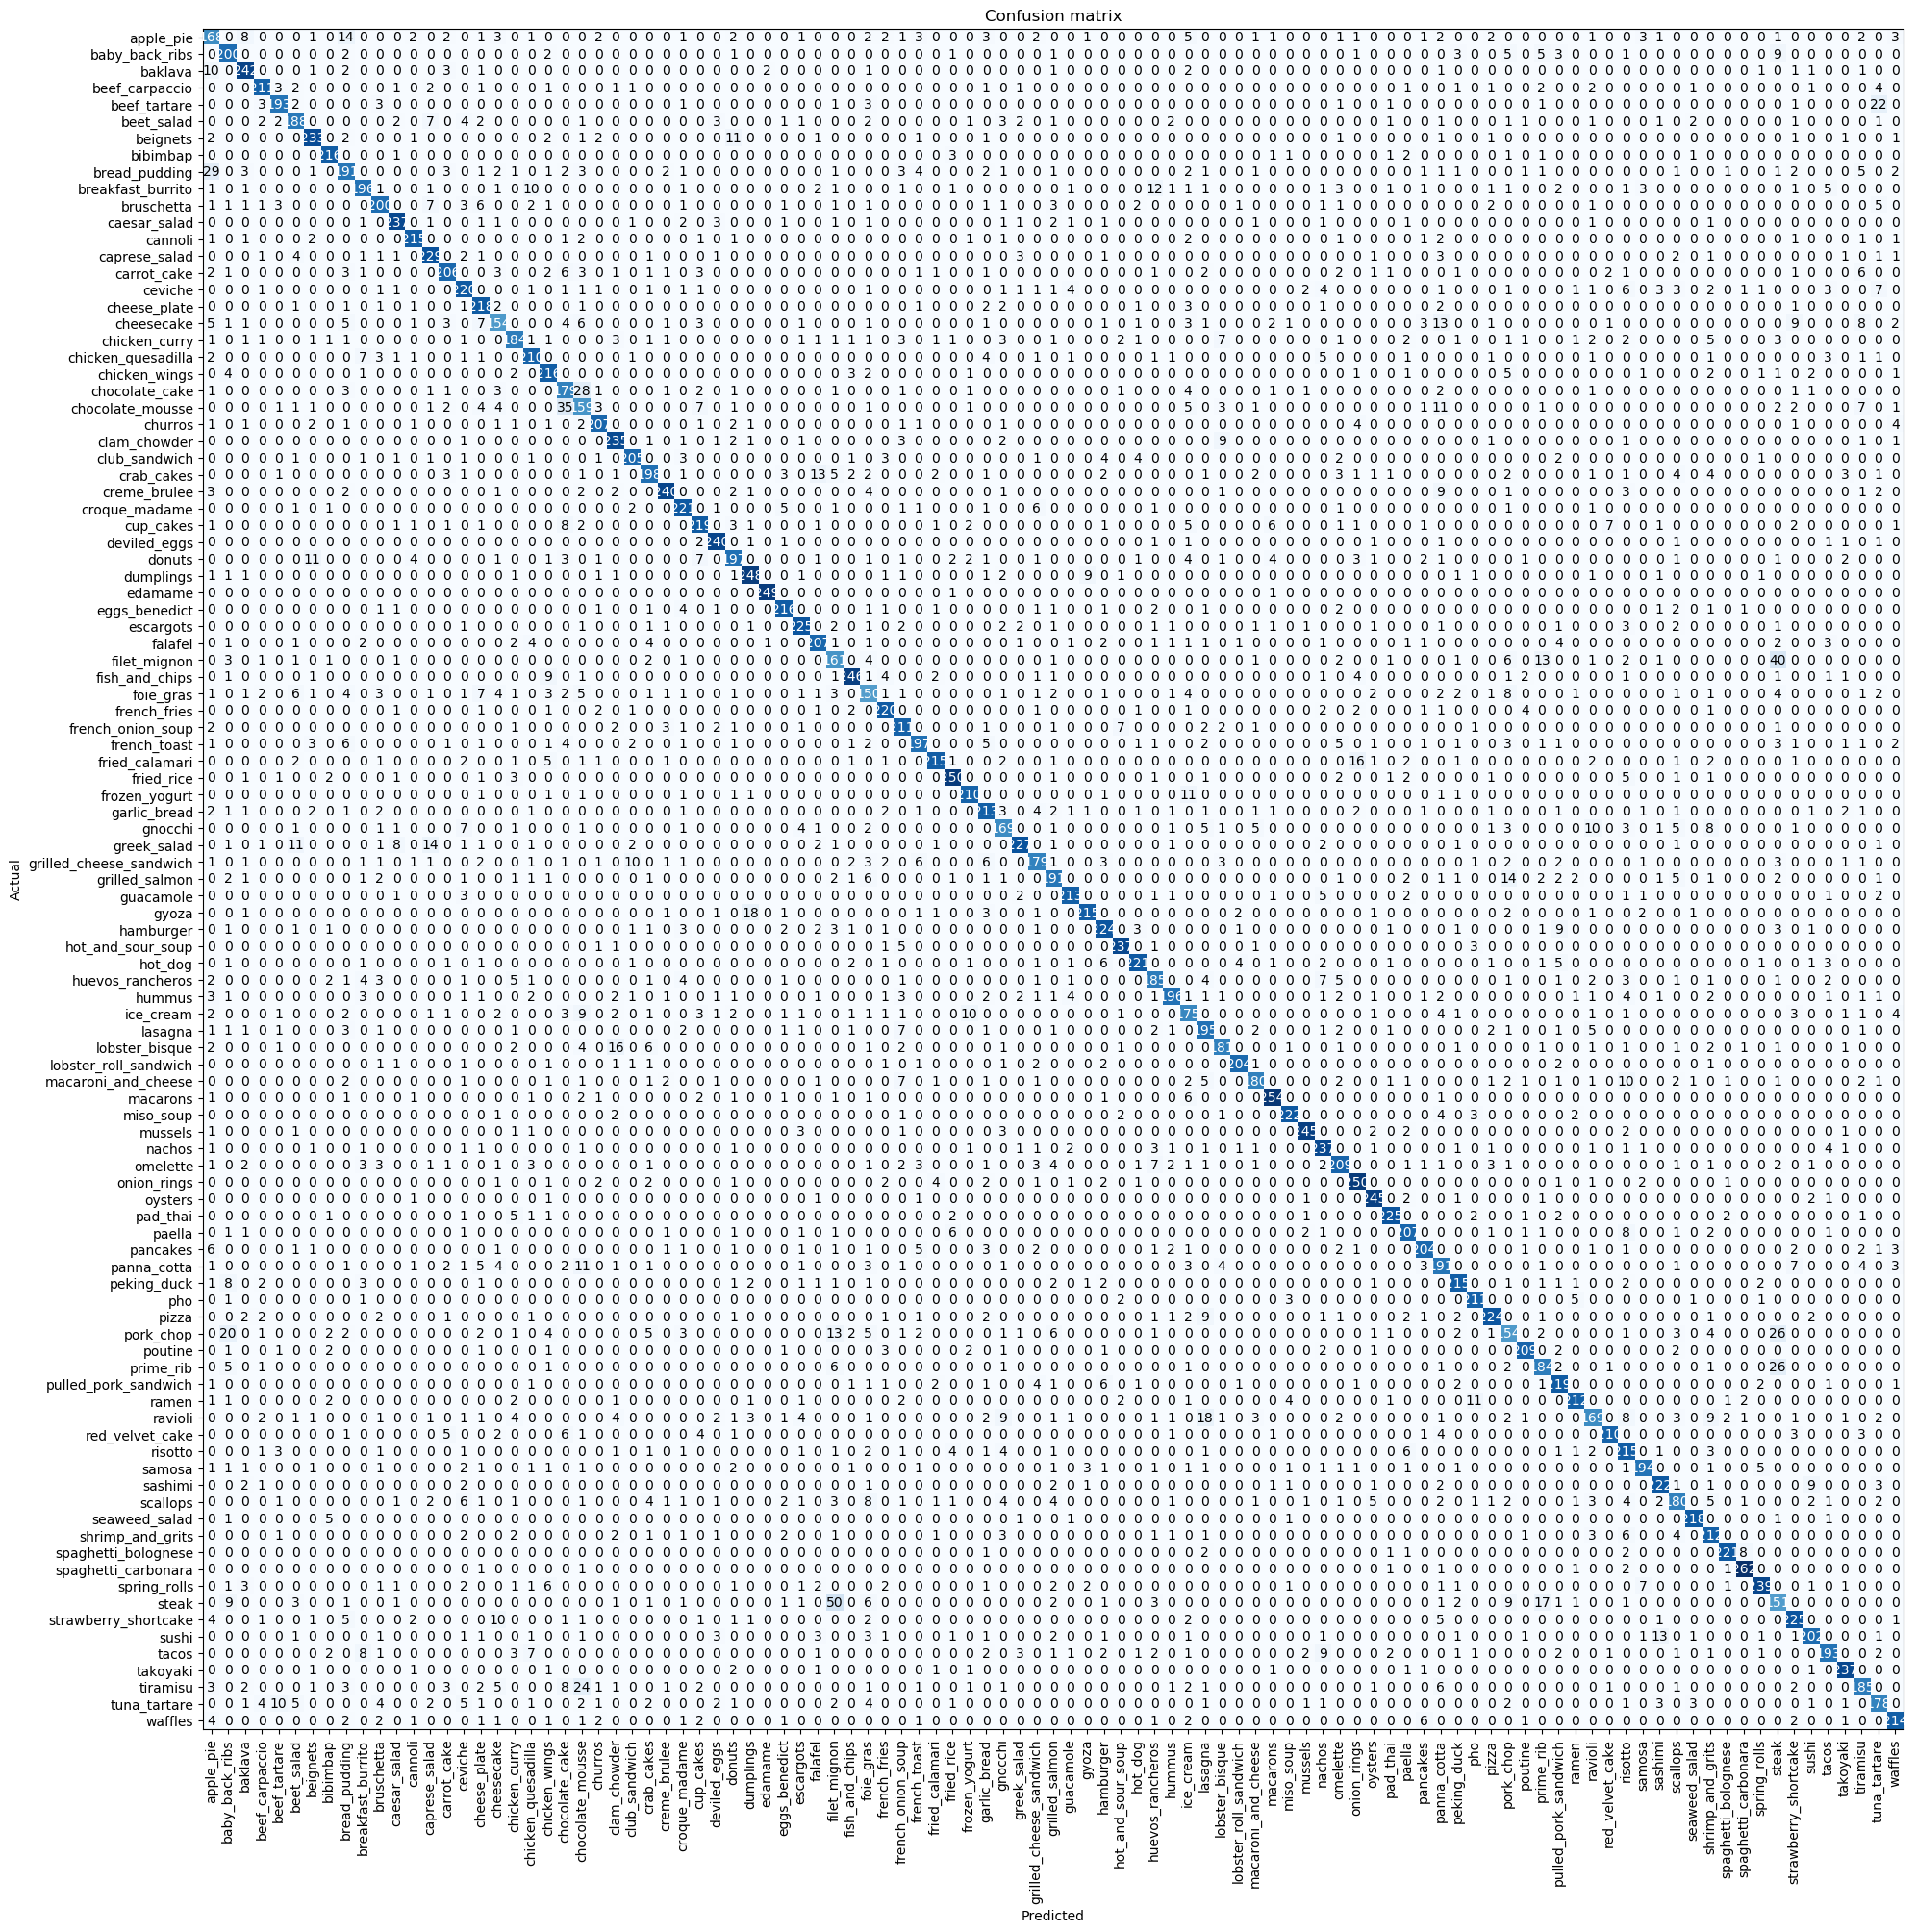

In [84]:
interp.plot_confusion_matrix(figsize=(20,20), dpi=100)


The most confused functions returns the tuple of classes that are the most confused. As en example, 'steak' and ' filet mignon ' have been mispredicted 50 times.

In [85]:
interp.most_confused(min_val=2)[:10]
# Grabs from the confusion matrix, the tuple that gots more confused and the number of times
#that got confusing.

[('steak', 'filet_mignon', 50),
 ('filet_mignon', 'steak', 40),
 ('chocolate_mousse', 'chocolate_cake', 35),
 ('bread_pudding', 'apple_pie', 29),
 ('chocolate_cake', 'chocolate_mousse', 28),
 ('pork_chop', 'steak', 26),
 ('prime_rib', 'steak', 26),
 ('tiramisu', 'chocolate_mousse', 24),
 ('beef_tartare', 'tuna_tartare', 22),
 ('pork_chop', 'baby_back_ribs', 20)]

Below I am plotting 1 example of steak and fillet mignon

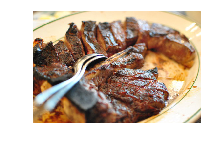

In [94]:
def get_ex(): return open_image(path_photos/'steak/101312.jpg')
image=get_ex()
image.show()
# This is a steak

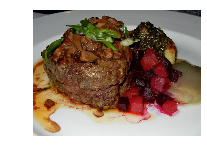

In [96]:
def get_ex(): return open_image(path_photos/'filet_mignon/1193043.jpg')
image=get_ex()
image.show()
# This is a filet_mignon

### Conclusions

a) As per the 'most confused' list, the model has high misclassification ratios between very simimlar catergories (ie. steak - fillet mignon and chocolate_mousse - chocolate cake ) which are even difficult to be distinguised by a human eye.

b) some images are incorrectly labelled ( i.e Macarrons and red velvet as shown in plot_top_losses)

c) The model don't achieve the accuracy target ( model accuracy= 83.92& Vs accuracy goal= 85% ). This target could be achieved with:
    - Better transformations: an increase in 'max_zoom' could help to get more accuracy as most of the food is not centered in the images.
    - Deeper model, which will make the training longer.